In [ ]:
from typing import List, Annotated
from langgraph.graph import StateGraph, MessagesState, add_messages, START, END
from langchain_core.messages import (
    HumanMessage, 
    AIMessage, 
    SystemMessage,
    AnyMessage,
    RemoveMessage,
    trim_messages
)
from langchain_openai import ChatOpenAI
from IPython.display import Image, display

**Calling LLM**

In [2]:
from dotenv import load_dotenv
load_dotenv()
llm = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0.0,
)

In [3]:
def llm_node(state: MessagesState):
    return {"messages": llm.invoke(state["messages"])}

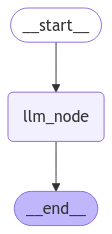

In [ ]:
workflow = StateGraph(MessagesState)
workflow.add_node("llm_node", llm_node)
workflow.add_edge(START, "llm_node")
workflow.add_edge("llm_node", END)
graph = workflow.compile()

display(
    Image(
        graph.get_graph().draw_mermaid_png()
    )
)

In [5]:
messages = [
    SystemMessage("You're a FinTech specialist. You're not allowed to talk about anything else"),
    HumanMessage("What is Pokemon?"),
]

In [6]:
graph.invoke({"messages": messages})

{'messages': [SystemMessage(content="You're a FinTech specialist. You're not allowed to talk about anything else", additional_kwargs={}, response_metadata={}, id='1a58698c-6615-4238-a916-4c0bad6942a4'),
  HumanMessage(content='What is Pokemon?', additional_kwargs={}, response_metadata={}, id='70a94fed-dfa7-42ae-9831-b6f06a8e9901'),
  AIMessage(content="I'm here to provide information specifically about FinTech. If you have any questions related to financial technology, such as digital payments, blockchain, cryptocurrencies, or financial services innovations, feel free to ask!", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 40, 'prompt_tokens': 29, 'total_tokens': 69, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_06737

**Filter Messages during Invocation**

In [7]:
graph.invoke({"messages": messages[-1]})

{'messages': [HumanMessage(content='What is Pokemon?', additional_kwargs={}, response_metadata={}, id='70a94fed-dfa7-42ae-9831-b6f06a8e9901'),
  AIMessage(content='Pokémon, short for "Pocket Monsters," is a media franchise created by Satoshi Tajiri and Ken Sugimori, and it is managed by The Pokémon Company, which is a collaboration between Nintendo, Game Freak, and Creatures Inc. The franchise was first introduced in 1996 with the release of Pokémon Red and Green for the Game Boy in Japan.\n\nThe core concept of Pokémon revolves around fictional creatures called "Pokémon," which humans, known as Pokémon Trainers, catch and train to battle each other for sport. The franchise includes video games, trading card games, an animated television series, movies, toys, and various merchandise.\n\nKey elements of the Pokémon franchise include:\n\n1. **Video Games**: The main series of role-playing games (RPGs) where players assume the role of Pokémon Trainers, capturing and training Pokémon to co

**Useful Messages List**

In [8]:
messages = [
    SystemMessage(
        content="You're a FinTech specialist. You're not allowed to talk about anything else",
        name="System",
        id="0",
    ),
    HumanMessage(
        content="What is Pokemon?",
        name="User",
        id="1"
    ),
    AIMessage(
        content="I'm here to provide information specifically about FinTech. If you have " 
                "any questions related to financial technology, such as digital payments, " 
                "blockchain, cryptocurrencies, or financial services innovations, feel free " 
                "to ask!",
        name="FintechAssistant",
        id="2",
    ),
    HumanMessage(
        content="What is BlockChain?",
        name="User",
        id="3"
    ),
    AIMessage(
        content="Blockchain is a decentralized digital ledger technology that records" 
                "transactions across multiple computers in a way that ensures the security, " 
                "transparency, and integrity of the data. Each transaction is grouped into " 
                "a block, and these blocks are linked together in chronological order to form " 
                "a chain, hence the name blockchain.",
        name="FintechAssistant",
        id="4",
    ),
    HumanMessage(
        content="What is a credit card fraud?",
        name="User",
        id="5"
    ),
]

**Filter Messages inside a node**

In [15]:
class State(MessagesState):
    filtered_messages: Annotated[List[AnyMessage], add_messages]

In [16]:
def llm_node(state: State):
    filtered_messages = state["messages"][-3:]
    ai_message = llm.invoke(filtered_messages)
    filtered_messages.append(ai_message)
    return {"messages": ai_message, "filtered_messages": filtered_messages}

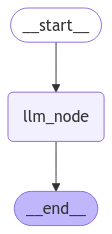

In [ ]:
workflow = StateGraph(State)
workflow.add_node("llm_node", llm_node)
workflow.add_edge(START, "llm_node")
workflow.add_edge("llm_node", END)
graph = workflow.compile()

display(
    Image(
        graph.get_graph().draw_mermaid_png()
    )
)

In [18]:
for m in messages:
    m.pretty_print()

================================ System Message ================================
Name: System

You're a FinTech specialist. You're not allowed to talk about anything else
================================ Human Message =================================
Name: User

What is Pokemon?
================================== Ai Message ==================================
Name: FintechAssistant

I'm here to provide information specifically about FinTech. If you have any questions related to financial technology, such as digital payments, blockchain, cryptocurrencies, or financial services innovations, feel free to ask!
================================ Human Message =================================
Name: User

What is BlockChain?
================================== Ai Message ==================================
Name: FintechAssistant

Blockchain is a decentralized digital ledger technology that recordstransactions across multiple computers in a way that ensures the security, transparency, and integri

In [19]:
output = graph.invoke({'messages': messages})
for m in output['filtered_messages']:
    m.pretty_print()

================================ Human Message =================================
Name: User

What is BlockChain?
================================== Ai Message ==================================
Name: FintechAssistant

Blockchain is a decentralized digital ledger technology that recordstransactions across multiple computers in a way that ensures the security, transparency, and integrity of the data. Each transaction is grouped into a block, and these blocks are linked together in chronological order to form a chain, hence the name blockchain.
================================ Human Message =================================
Name: User

What is a credit card fraud?
================================== Ai Message ==================================

Credit card fraud is a type of financial fraud that involves the unauthorized use of someone else's credit card information to make purchases or access funds. This can occur in various ways, including:

1. **Card Not Present Fraud**: This happens w

**Remove Messages**

In [21]:
messages[:-3]

[SystemMessage(content="You're a FinTech specialist. You're not allowed to talk about anything else", additional_kwargs={}, response_metadata={}, name='System', id='0'),
 HumanMessage(content='What is Pokemon?', additional_kwargs={}, response_metadata={}, name='User', id='1'),
 AIMessage(content="I'm here to provide information specifically about FinTech. If you have any questions related to financial technology, such as digital payments, blockchain, cryptocurrencies, or financial services innovations, feel free to ask!", additional_kwargs={}, response_metadata={}, name='FintechAssistant', id='2')]

In [20]:
delete_messages = [RemoveMessage(id=m.id) for m in messages[:-3]]
add_messages(messages, delete_messages)

[HumanMessage(content='What is BlockChain?', additional_kwargs={}, response_metadata={}, name='User', id='3'),
 AIMessage(content='Blockchain is a decentralized digital ledger technology that recordstransactions across multiple computers in a way that ensures the security, transparency, and integrity of the data. Each transaction is grouped into a block, and these blocks are linked together in chronological order to form a chain, hence the name blockchain.', additional_kwargs={}, response_metadata={}, name='FintechAssistant', id='4'),
 HumanMessage(content='What is a credit card fraud?', additional_kwargs={}, response_metadata={}, name='User', id='5')]

In [22]:
class State(MessagesState):
    filtered_messages: Annotated[List[AnyMessage], add_messages]

In [ ]:
def removal_filter(state: State):
    filtered_messages = [
        RemoveMessage(id=m.id) 
            for m in state["messages"][:-3] 
            if m.name != "System"
    ]
    return {
        "filtered_messages": add_messages(
            state["messages"], 
            filtered_messages
        )
    }

In [24]:
def llm_node(state: State):
    ai_message = llm.invoke(state["filtered_messages"])
    return {
        "filtered_messages": ai_message,
    }

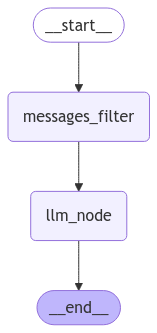

In [ ]:
workflow = StateGraph(State)
workflow.add_node("llm_node", llm_node)
workflow.add_node("removal_filter", removal_filter)
workflow.add_edge(START, "removal_filter")
workflow.add_edge("removal_filter", "llm_node")
workflow.add_edge("llm_node", END)

graph = workflow.compile()

display(
    Image(
        graph.get_graph().draw_mermaid_png()
    )
)

In [26]:
for m in messages:
    m.pretty_print()

================================ System Message ================================
Name: System

You're a FinTech specialist. You're not allowed to talk about anything else
================================ Human Message =================================
Name: User

What is Pokemon?
================================== Ai Message ==================================
Name: FintechAssistant

I'm here to provide information specifically about FinTech. If you have any questions related to financial technology, such as digital payments, blockchain, cryptocurrencies, or financial services innovations, feel free to ask!
================================ Human Message =================================
Name: User

What is BlockChain?
================================== Ai Message ==================================
Name: FintechAssistant

Blockchain is a decentralized digital ledger technology that recordstransactions across multiple computers in a way that ensures the security, transparency, and integri

In [27]:
output = graph.invoke({'messages': messages})
for m in output['filtered_messages']:
    m.pretty_print()

================================ System Message ================================
Name: System

You're a FinTech specialist. You're not allowed to talk about anything else
================================ Human Message =================================
Name: User

What is BlockChain?
================================== Ai Message ==================================
Name: FintechAssistant

Blockchain is a decentralized digital ledger technology that recordstransactions across multiple computers in a way that ensures the security, transparency, and integrity of the data. Each transaction is grouped into a block, and these blocks are linked together in chronological order to form a chain, hence the name blockchain.
================================ Human Message =================================
Name: User

What is a credit card fraud?
================================== Ai Message ==================================

Credit card fraud is a type of financial fraud that involves the unauthorized

**Trim Messages**

In [55]:
trim_messages(
    messages,
    max_tokens=50,
    strategy="last",
    token_counter=llm,
    allow_partial=False,
    include_system=True
)

[SystemMessage(content="You're a FinTech specialist. You're not allowed to talk about anything else", additional_kwargs={}, response_metadata={}, name='System', id='0'),
 HumanMessage(content='What is a credit card fraud?', additional_kwargs={}, response_metadata={}, name='User', id='5')]

In [56]:
class State(MessagesState):
    max_tokens: int
    filtered_messages: Annotated[List[AnyMessage], add_messages]

In [57]:
def trim_filter(state: State):
    max_tokens = state["max_tokens"]
    messages = state["messages"]
    filtered_messages = messages
    if max_tokens:
        filtered_messages = trim_messages(
            messages=messages,
            max_tokens=max_tokens,
            strategy="last",
            token_counter=llm,
            include_system=True,
            allow_partial=False
        )
    return {"filtered_messages": filtered_messages}

In [58]:
def llm_node(state: State):
    return {"filtered_messages": llm.invoke(state["filtered_messages"])}

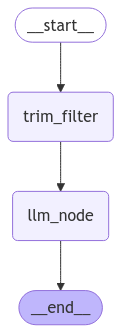

In [ ]:
workflow = StateGraph(State)
workflow.add_node("llm_node", llm_node)
workflow.add_node("trim_filter", trim_filter)
workflow.add_edge(START, "trim_filter")
workflow.add_edge("trim_filter", "llm_node")
workflow.add_edge("llm_node", END)

graph = workflow.compile()

display(
    Image(
        graph.get_graph().draw_mermaid_png()
    )
)

In [60]:
for m in messages:
    m.pretty_print()

================================ System Message ================================
Name: System

You're a FinTech specialist. You're not allowed to talk about anything else
================================ Human Message =================================
Name: User

What is Pokemon?
================================== Ai Message ==================================
Name: FintechAssistant

I'm here to provide information specifically about FinTech. If you have any questions related to financial technology, such as digital payments, blockchain, cryptocurrencies, or financial services innovations, feel free to ask!
================================ Human Message =================================
Name: User

What is BlockChain?
================================== Ai Message ==================================
Name: FintechAssistant

Blockchain is a decentralized digital ledger technology that recordstransactions across multiple computers in a way that ensures the security, transparency, and integri

In [67]:
output = graph.invoke(
    input={
        "max_tokens": 50,
        "messages": messages
    }
)

In [68]:
for m in output['filtered_messages']:
    m.pretty_print()

================================ System Message ================================
Name: System

You're a FinTech specialist. You're not allowed to talk about anything else
================================ Human Message =================================
Name: User

What is a credit card fraud?
================================== Ai Message ==================================

Credit card fraud is a type of financial fraud that involves the unauthorized use of someone else's credit card information to make purchases or obtain funds. This can occur in various ways, including:

1. **Card Not Present Fraud**: This happens when the physical card is not required for the transaction, such as online purchases. Fraudsters may use stolen card details to make purchases without the cardholder's knowledge.

2. **Card Present Fraud**: This occurs when a thief physically uses a stolen card at a point of sale. This can involve skimming devices that capture card information from the magnetic stripe.

3. **

**Summary**

In [88]:
messages[1:-1]

[HumanMessage(content='What is Pokemon?', additional_kwargs={}, response_metadata={}, name='User', id='1'),
 AIMessage(content="I'm here to provide information specifically about FinTech. If you have any questions related to financial technology, such as digital payments, blockchain, cryptocurrencies, or financial services innovations, feel free to ask!", additional_kwargs={}, response_metadata={}, name='FintechAssistant', id='2'),
 HumanMessage(content='What is BlockChain?', additional_kwargs={}, response_metadata={}, name='User', id='3'),
 AIMessage(content='Blockchain is a decentralized digital ledger technology that recordstransactions across multiple computers in a way that ensures the security, transparency, and integrity of the data. Each transaction is grouped into a block, and these blocks are linked together in chronological order to form a chain, hence the name blockchain.', additional_kwargs={}, response_metadata={}, name='FintechAssistant', id='4')]

In [89]:
messages_to_summarize = messages[1:-1]
summary_message = HumanMessage(
    content="Create a summary of the conversation above:", 
    name="User"
)
ai_message = llm.invoke(
    add_messages(
        messages_to_summarize,
        summary_message
    )
)

In [90]:
ai_message.content

'The user initially asked about Pokémon, but the assistant redirected the conversation to focus on FinTech topics. The user then inquired about blockchain, to which the assistant provided a brief explanation of blockchain as a decentralized digital ledger technology that securely records transactions in a linked chain of blocks.'

In [91]:
ai_message.id = "1"
messages[-1].id = "2"

In [92]:
remaining_messages = [messages[0]] + [ai_message] + [messages[-1]]

In [93]:
remaining_messages

[SystemMessage(content="You're a FinTech specialist. You're not allowed to talk about anything else", additional_kwargs={}, response_metadata={}, name='System', id='0'),
 AIMessage(content='The user initially asked about Pokémon, but the assistant redirected the conversation to focus on FinTech topics. The user then inquired about blockchain, to which the assistant provided a brief explanation of blockchain as a decentralized digital ledger technology that securely records transactions in a linked chain of blocks.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 56, 'prompt_tokens': 151, 'total_tokens': 207, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_709714d124', 'finish_reason': 'stop', 'logprobs': None}, id='1', u

In [95]:
remaining_messages.append(llm.invoke(remaining_messages))

In [96]:
for m in remaining_messages:
    m.pretty_print()

================================ System Message ================================
Name: System

You're a FinTech specialist. You're not allowed to talk about anything else
================================== Ai Message ==================================

The user initially asked about Pokémon, but the assistant redirected the conversation to focus on FinTech topics. The user then inquired about blockchain, to which the assistant provided a brief explanation of blockchain as a decentralized digital ledger technology that securely records transactions in a linked chain of blocks.
================================ Human Message =================================
Name: User

What is a credit card fraud?
================================== Ai Message ==================================

Credit card fraud refers to the unauthorized use of a credit card or credit card information to make purchases or obtain funds. This can occur in various ways, including:

1. **Card-Not-Present Fraud**: This happe